# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pyreadr

from joblib import dump, load

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report

sns.set_context('paper')
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(font_scale = 1.4)
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None


# Functions to Pull and Clean data

In [2]:
start_season = 2011
end_season = 2020

In [3]:
# a function to grab play-by-play data between season start year ranges
def get_pbp(year_start, year_end):
    years = np.arange(year_start, year_end + 1, 1)
    df = pd.DataFrame()
    for year in years:
        filename = f'https://github.com/guga31bb/nflfastR-data/raw/master/data/play_by_play_{year}.csv.gz'
        print(f'Getting play-by-play data for the {year}-{year+1} NFL season.')
        pbp_df = pd.read_csv(filename, compression = 'gzip', low_memory = False)
        df = df.append(pbp_df, sort = True)
    df.reset_index(drop = True, inplace = True)
    
    return df

# a function to grab schedule data between season start year ranges
def get_schedules(year_start, year_end):
    years = np.arange(year_start, year_end+1, 1)
    df = pd.DataFrame()
    for year in years:
        print(f'Getting schedule data from {year}-{year+1} NFL season.')
        sched_year = f'sched_{year}.rds'
        url = f'https://github.com/guga31bb/nflfastR-data/raw/master/schedules/{sched_year}'
        dst_path = f'data/schedule_R_data/{sched_year}'
        dst_path_again = pyreadr.download_file(url, dst_path)
        data = pyreadr.read_r(dst_path)
        df = df.append(data[None], sort = True)
    df.reset_index(drop = True, inplace = True)
    
    return df

# a function to get a response variable by merging PbP and schedule data
def get_response_variable(pbp, sched):
    # determine the winner for a game
    print('Determining winner based on score.')
    sched['winner'] = sched.apply(lambda x: [x['home_team'] if x['home_score'] > x['away_score'] else x['away_team']], 
                                  axis = 1)
    sched['winner'] = sched['winner'].str[0]

    # merge dataframes on key 'game_id'
    print('Merging dataframes on game ID.')
    df = pbp.merge(sched, on = 'game_id', how = 'outer')
    
    # determine is the team in possession of the ball is the winner
    print('Determining if team in possession of the ball is the winner.')
    df['poswins'] = df.apply(lambda x: ['Yes' if x['winner'] == x['posteam'] else 'No'], axis = 1)
    df['poswins'] = df['poswins'].str[0]
    
    # filter out play types that are no play, 5th quarters, null downs and null poswins
    print('Filtering out No Plays, 5th quarters, null downs and null poswins.')
    np_qtr_5_mask = (df['play_type'] != 'no_play') & (df['qtr'] != 5) & (df['qtr'] != 6) & (df['down'].notnull()) & (df['poswins'].notnull())
    df_reduced = df[np_qtr_5_mask]
    
    cols_to_keep = ['game_id', 'gameday', 'posteam', 'touchdown', 'field_goal_result', 'home_team_x', 'away_team_x', 'qtr', 'down', 
                    'ydstogo', 'game_seconds_remaining', 'yardline_100', 'score_differential', 'half_seconds_remaining', 
                    'home_timeouts_remaining', 'away_timeouts_remaining', 'poswins']
    df_reduced = df_reduced[cols_to_keep]
    
    df_reduced['adjusted_score'] = df_reduced.apply(lambda x: x['score_differential'] / (np.sqrt(x['game_seconds_remaining'] + 1)), axis = 1)
    
    df_reduced.rename(columns = {'home_team_x': 'home_team', 'away_team_x': 'away_team'}, inplace = True)
    
    
    print('Saving file as CSV.')
    filename = 'win_prob_data.csv'
    df_reduced.to_csv(f'data/{filename}', index = False)
    print(f'CSV successfully saved. The filename is {filename}')

# a function to set up a data pipeline
def get_data():
    pbp = get_pbp(start_season, end_season)
    sched = get_schedules(start_season, end_season)
    get_response_variable(pbp, sched)

# Question 1: Create a win probability model that will help us determine the impact of each play we run. For starters include: down, distance, yard line, time left in the game and point differential.

> Uncomment if you want to run

In [4]:
# get_data()

## Data Preparation

### Import Data

In [5]:
win_prob_data = pd.read_csv('data/win_prob_data.csv')
win_prob_data.head()

,game_id,gameday,posteam,touchdown,field_goal_result,home_team,away_team,qtr,down,ydstogo,game_seconds_remaining,yardline_100,score_differential,half_seconds_remaining,home_timeouts_remaining,away_timeouts_remaining,poswins,adjusted_score
0,2011_01_ATL_CHI,2011-09-11,CHI,0.0,NaN,CHI,ATL,1,1.0,10,3590.0,77.0,0.0,1790.0,3,3,Yes,0.0
1,2011_01_ATL_CHI,2011-09-11,CHI,0.0,NaN,CHI,ATL,1,2.0,13,3557.0,80.0,0.0,1757.0,3,3,Yes,0.0
2,2011_01_ATL_CHI,2011-09-11,CHI,0.0,NaN,CHI,ATL,1,3.0,6,3517.0,73.0,0.0,1717.0,3,3,Yes,0.0
3,2011_01_ATL_CHI,2011-09-11,CHI,0.0,NaN,CHI,ATL,1,1.0,10,3491.0,50.0,0.0,1691.0,3,3,Yes,0.0
4,2011_01_ATL_CHI,2011-09-11,CHI,0.0,NaN,CHI,ATL,1,2.0,10,3453.0,50.0,0.0,1653.0,3,3,Yes,0.0


In [6]:
non_predictors = ['game_id', 'gameday', 'posteam', 'home_team', 'away_team', 
                 'qtr', 'down', 'touchdown', 'field_goal_result', 'poswins']
cat_features = ['qtr', 'down']

print('Converting features to categorical features.')
dummies = pd.get_dummies(data = win_prob_data[cat_features], columns = cat_features)
win_prob_data = pd.concat([win_prob_data, dummies], axis = 1)

X = win_prob_data.drop(non_predictors, axis = 1)
y = win_prob_data['poswins']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Converting features to categorical features.


## Modeling
> I use 5 modeling techniques to figure out the best models. These are **Logistic Regression**, **Decision Trees**, **Random Forest**, **Stochastic Gradient Descent**, and **K-Nearest Neighbors Classifier**.

In [7]:
def cr(y_test, y_pred, digits = 4):
    print(classification_report(y_test, y_pred, digits = digits))

In [8]:
def run_pipeline(model, model_name):
    print(f'Fitting model for {model_name}.', end = '\n\n')
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    cr(y_test, y_pred)
    print(f'Saving {model_name} model.')
    filename = f'{model_name}.joblib'
    dump(model, f'models/{filename}')
    print(f'Model saved successfully. The filename is {filename}', end = '\n\n\n')

### Logistic Regression, Decision Tree, Random Forest, KNeighborsClassifier, and SGDClassifier

In [9]:
lr_clf = LogisticRegression(C = 0.01, max_iter = 3000, 
                            random_state = 42, n_jobs = -1)
tree_clf = DecisionTreeClassifier(max_depth = 10, random_state = 42)
rf_clf = RandomForestClassifier(n_estimators = 100, random_state = 42, 
                                n_jobs = -1, max_depth = 10)
knn_clf = KNeighborsClassifier(n_neighbors = 30)
sgd_clf = SGDClassifier(random_state = 42)

### Fitting all models and outputting results
> Uncomment if you want to run. I stored the models using joblib so I did not have to re-train models later.

In [10]:
# models = [lr_clf, tree_clf, rf_clf, knn_clf, sgd_clf]
# model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'KNeighbors', 'Stochastic Gradient Descent']

# for name, model in enumerate(models):
#     run_pipeline(model, model_names[name])

# Question 2: Use the model you created to describe one game from the previous season. Include a visual display that has the time left in the game referenced on the x-axis and the win probability referenced on the y-axis. Describe and explain large shifts in win probability from the game, focusing on specific plays and or drives that best explain these shifts.

## Data Preparation
> I isolate the game that took place and prepare the data for being predicted on by the model. Data has to be standardized according to the standard scaler.

> Game IDs follow the format Year_Week Number_Team1_Team2

In [11]:
dec_6th_game_NO_ATL = win_prob_data['game_id'] == '2020_13_NO_ATL'
saints_vs_falc_2020 = win_prob_data[dec_6th_game_NO_ATL]
saints_vs_falc_2020.head()

,game_id,gameday,posteam,touchdown,field_goal_result,home_team,away_team,qtr,down,ydstogo,game_seconds_remaining,yardline_100,score_differential,half_seconds_remaining,home_timeouts_remaining,away_timeouts_remaining,poswins,adjusted_score,qtr_1,qtr_2,qtr_3,qtr_4,down_1.0,down_2.0,down_3.0,down_4.0
362646,2020_13_NO_ATL,2020-12-06,ATL,0.0,NaN,ATL,NO,1,1.0,10,3600.0,75.0,0.0,1800.0,3,3,No,0.0,1,0,0,0,1,0,0,0
362647,2020_13_NO_ATL,2020-12-06,ATL,0.0,NaN,ATL,NO,1,2.0,6,3567.0,71.0,0.0,1767.0,3,3,No,0.0,1,0,0,0,0,1,0,0
362648,2020_13_NO_ATL,2020-12-06,ATL,0.0,NaN,ATL,NO,1,3.0,4,3531.0,69.0,0.0,1731.0,3,3,No,0.0,1,0,0,0,0,0,1,0
362649,2020_13_NO_ATL,2020-12-06,ATL,0.0,NaN,ATL,NO,1,4.0,4,3525.0,69.0,0.0,1725.0,3,3,No,0.0,1,0,0,0,0,0,0,1
362650,2020_13_NO_ATL,2020-12-06,NO,0.0,NaN,ATL,NO,1,1.0,10,3514.0,93.0,0.0,1714.0,3,3,Yes,0.0,1,0,0,0,1,0,0,0


In [12]:
# isolating model data from miscellaneous game data
misc_info = saints_vs_falc_2020.iloc[:, :9]
model_data = saints_vs_falc_2020.iloc[:, 9:]

X = model_data.drop('poswins', axis = 1)
y = model_data['poswins']

# standardizing data
X_scaled = scaler.fit_transform(X)

## Modeling

In [13]:
model = load('models/Logistic Regression.joblib')

In [14]:
def determine_fieldgoal_result(fg):
    if fg == 'made':
        return 'FG made'
    elif fg == 'missed':
        return 'FG missed'
    else:
        return 'Null'

In [15]:
preds = pd.DataFrame(model.predict_proba(X_scaled), columns = model.classes_)
df = pd.concat([misc_info.reset_index(), model_data.reset_index(), preds], axis = 1)
df.drop('index', axis = 1, inplace = True)

saints_mask = df['posteam'] == 'NO'
falcons_mask = df['posteam'] == 'ATL'

# calculate win probability for each team based on the class labels
df['saints_win_prob'] = df.apply(lambda x: x['Yes'] if x['posteam'] == 'NO' else x['No'], axis = 1)
df['saints_TD'] = df[saints_mask].apply(lambda x: 'TD' if x['touchdown'] == 1 and x['posteam'] == 'NO' else 'No', axis = 1)
df['saints_FG'] = df[saints_mask].apply(lambda x: determine_fieldgoal_result(x['field_goal_result']), axis = 1)

df['falcons_win_prob'] = df.apply(lambda x: x['Yes'] if x['posteam'] == 'ATL' else x['No'], axis = 1)
df['falcons_TD'] = df[falcons_mask].apply(lambda x: 'TD' if x['touchdown'] == 1 and x['posteam'] == 'ATL' else 'No', axis = 1)
df['falcons_FG'] = df[falcons_mask].apply(lambda x: determine_fieldgoal_result(x['field_goal_result']), axis = 1)

# isolate touchdowns and field goals
saints_tds = df[df['saints_TD'] == 'TD']
saints_fgs = df[df['saints_FG'] == 'FG made']
saints_fgs_missed = df[df['saints_FG'] == 'FG missed']
atl_tds = df[df['falcons_TD'] == 'TD']
atl_fgs = df[df['falcons_FG'] == 'FG made']
atl_fgs_missed = df[df['falcons_FG'] == 'FG missed']

# determining saints possessions versus falcons possessions
df['poss_changes'] = df['posteam'].map({'NO': 0, 'ATL': 1}).diff()
saints_pos = df[df['poss_changes']== -1]
atl_pos = df[df['poss_changes'] == 1]

## Evaluating Win Probability

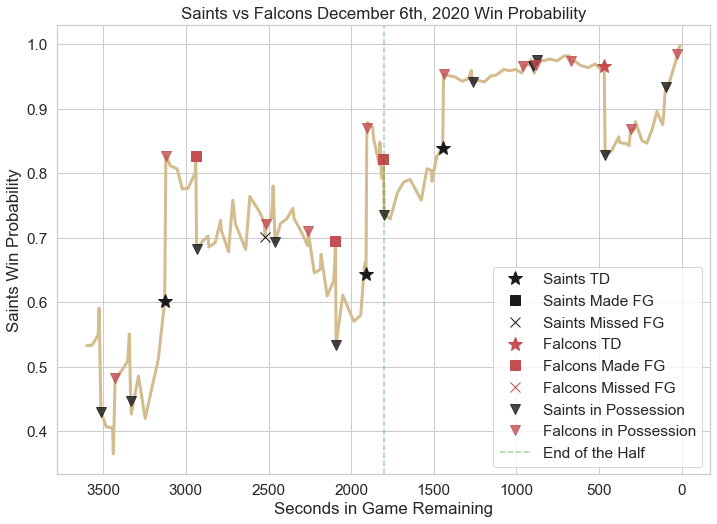

In [16]:
g = sns.lineplot(x = 'game_seconds_remaining', y = 'saints_win_prob', data = df, color = '#D3BC8D', linewidth = 3)
g.invert_xaxis()

# plot New Orlean's TDs and FGAs
g.plot(saints_tds['game_seconds_remaining'], saints_tds['saints_win_prob'], 'k*', label = 'Saints TD',
       markersize = 15)
g.plot(saints_fgs['game_seconds_remaining'], saints_fgs['saints_win_prob'], 'ks', label = 'Saints Made FG',
       markersize = 10)
g.plot(saints_fgs_missed['game_seconds_remaining'], saints_fgs_missed['saints_win_prob'], 'kx', label = 'Saints Missed FG',
       markersize = 10)

# plot Atlanta's TDs and FGAs
g.plot(atl_tds['game_seconds_remaining'], atl_tds['saints_win_prob'], 'r*', label = 'Falcons TD', 
       markersize = 15)
g.plot(atl_fgs['game_seconds_remaining'], atl_fgs['saints_win_prob'], 'rs', label = 'Falcons Made FG',
       markersize = 10)
g.plot(atl_fgs_missed['game_seconds_remaining'], atl_fgs_missed['saints_win_prob'], 'rx', label = 'Falcons Missed FG',
       markersize = 10)

# plotting possessions
g.plot(saints_pos['game_seconds_remaining'], saints_pos['saints_win_prob'], 'kv', label = 'Saints in Possession',
       markersize = 10, alpha = 0.8)
g.plot(atl_pos['game_seconds_remaining'], atl_pos['saints_win_prob'], 'rv', label = 'Falcons in Possession',
       markersize = 10, alpha = 0.8)

# plot vertical line for half-time
plt.axvline(x = 1800, label = 'End of the Half', linestyle = 'dashed', color = 'green', alpha = 0.35)

plt.ylabel('Saints Win Probability')
plt.xlabel('Seconds in Game Remaining')
plt.title('Saints vs Falcons December 6th, 2020 Win Probability')
plt.legend()
plt.savefig('images/saintsvsfalconswinprob.png', bbox_inches = 'tight')
plt.show()

## Evaluating Model Feature Importances

ydstogo: -0.03378022966827779
game_seconds_remaining: -0.019740691938098073
yardline_100: -0.2059781492206073
score_differential: 1.0294404430671678
half_seconds_remaining: -0.03165868864511504
home_timeouts_remaining: -0.0028884009009164033
away_timeouts_remaining: -0.004532322024423973
adjusted_score: 1.223885456756668
qtr_1: 0.014568939889710362
qtr_2: -0.01799509983590884
qtr_3: 0.0005330226747420131
qtr_4: 0.0037739263569231823
down_1.0: 0.055763908643369005
down_2.0: 0.015027598420486562
down_3.0: -0.02836896419200888
down_4.0: -0.07597415971281676


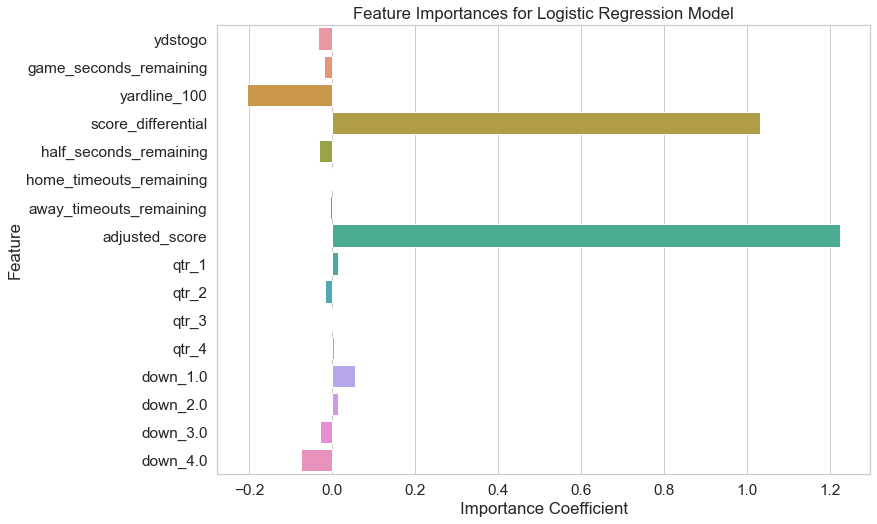

In [17]:
importance = model.coef_[0]
features = X.columns.tolist()
for coef, feature in enumerate(features):
    print(f'{feature}: {importance[coef]}')

sns.barplot(x = importance, y = features)
plt.xlabel('Importance Coefficient')
plt.ylabel('Feature')
title = 'Feature Importances for Logistic Regression Model'
plt.title(title)
plt.savefig(f'images/{title}.png', bbox_inches = 'tight')
plt.show()

# Question 4: Pick a chapter (18-27) from “Mathletics” and provide a brief description of the topic discussed. Explain how this will help our organization in the future and include analysis and data from last year (or several years).

## Data Preparation

In [18]:
# filter by field goal results that are not null
field_goal_data = win_prob_data[win_prob_data['field_goal_result'].notnull()]
fg_df = field_goal_data[['field_goal_result', 'yardline_100']] 

# adding 7 yards for field goal for kicker's place
fg_df['yardline_100'] = fg_df['yardline_100'].apply(lambda x: x + 7.0 + 10.0)

# preparing data
X = fg_df['yardline_100'].values.reshape(-1, 1)
y = fg_df['field_goal_result']
X_test = np.arange(0, 66, 1).reshape(-1, 1)

## Modeling + Evaluation

In [19]:
logreg_model = LogisticRegression(max_iter = 3000)
logreg_model.fit(X, y)

LogisticRegression(max_iter=3000)

In [20]:
model_info = pd.DataFrame(logreg_model.predict_proba(X_test), columns = logreg_model.classes_)
X_test_s = pd.Series(np.arange(0, 66, 1))
model_info = pd.concat([model_info, X_test_s], axis = 1)
model_info.rename(columns = {0: 'yardline'}, inplace = True)

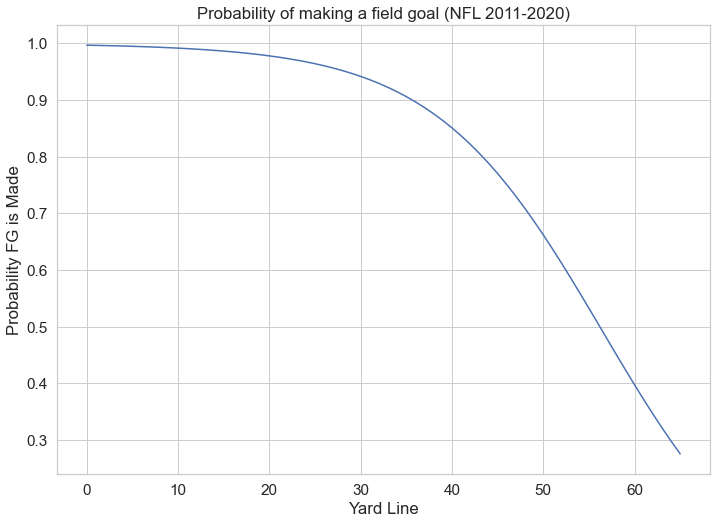

In [21]:
sns.lineplot(x = 'yardline', y = 'made', data = model_info)
title = 'Probability of making a field goal (NFL 2011-2020)'
plt.xlabel('Yard Line')
plt.ylabel('Probability FG is Made')
plt.title(title)
plt.savefig(f'images/{title}.png', bbox_inches = 'tight')
plt.show()

> Here I'll pull the probability of a field goals made from 47 yards away.

In [22]:
model_info[model_info['yardline'] == 47] 

,blocked,made,missed,yardline
47,0.029118,0.730014,0.240867,47
